In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install opencv-python

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import csv

device = 'cuda:0' 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# BoostNet Dataset
# from SpineWeb dataset16
# link: http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets

class BoostNetDataset(torch.utils.data.Dataset):
    def __init__(self, path, train=True):
        self.images = []
        self.labels = []
        
        if train:
            image_path = path + "/content/drive/MyDrive/data/training/"
            names = csv.reader(open(path + "/content/drive/MyDrive/labels/training/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/content/drive/MyDrive/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/content/drive/MyDrive/data/test/"
            names = csv.reader(open(path + "/content/drive/MyDrive/labels/test/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/content/drive/MyDrive/labels/test/landmarks.csv", 'r'))
        
        
        for landmark_each_image in landmarks:
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))
            self.labels.append(torch.Tensor(coordinate_list))

        for i, name in enumerate(names):
            origin_image = cv.imread(image_path + name[0], cv.IMREAD_GRAYSCALE)
      
            # print("origin image shape:", origin_image.shape)
            # print("shape[0]", origin_image.shape[0])
            #print("name[0]:", name[0])
            target_height = 256
            target_width = 128
            image = np.zeros((target_height, target_width), np.uint8)
            
            
    
            cv.resize(origin_image, (target_width, target_height), image)
            

            image = np.reshape(image, (1, image.shape[0], image.shape[1]))
            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)
            # else:
            #   print("image: ", name, " name[0]:", name[0], "corrupt.")
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [ ]:
# initialize the train and test data loader
train_data = BoostNetDataset("", train=True)
test_data = BoostNetDataset("", train=False)

batch = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                         shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,
                                         shuffle=True, num_workers=2)


print("number of batches(training): ", len(train_loader))
print("number of batches(testing): ",len(test_loader))

number of batches(training):  31
number of batches(testing):  8


In [ ]:
# define network

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        # the first 4-parts convolutional layers in paper to extract features
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=(1,2))
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=400, kernel_size=5, stride=1, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        return x 

class BoostLayer(nn.Module):
    def __init__(self, input_channel, output_channel, h, w):
        super(BoostLayer, self).__init__()
        self.height = h
        self.width = w
        
        self.encoder_weight = nn.Parameter(torch.randn(h * w, h * w))
        self.encoder_bias_1 = nn.Parameter(torch.randn(h * w))
        self.encoder_bias_2 = nn.Parameter(torch.randn(h * w))

        print("Parameter.shape:", self.encoder_weight.shape)

        self.average = torch.zeros((input_channel, h, w), requires_grad=False).to(device)
        self.sigma_square = torch.zeros((input_channel, h, w), requires_grad=False).to(device)
        
    def update_avg_cov(self, avg, cov):
        assert(avg.shape == self.average.shape)
        assert(cov.shape == self.sigma_square.shape)
        
        self.average = avg
        self.sigma_square = cov
    
    def forward(self, x):
        x = x.flatten(2,3)
        #print("BoostLAYER: x.shape: ", x.shape)
        encode_x = nn.functional.relu(nn.functional.linear(x, self.encoder_weight, self.encoder_bias_1))
        #print("BoostLAYER: encode.shape: ", encode_x.shape)
        decoder_weight = self.encoder_weight.transpose(0, 1)
        #print("BoostLAYER: .shape: ", encode_x.shape)
        r = nn.functional.linear(encode_x, decoder_weight, self.encoder_bias_2)

        x = x.reshape(x.shape[0], x.shape[1], self.height, self.width)
        r = r.reshape(r.shape[0], r.shape[1], self.height, self.width)

        epsilon = (x - r).pow(2)  
        x_hat = x.clone()
        
        batch_size = x.shape[0]
        
        for i in range(batch_size):
            outliers = epsilon[i] > self.sigma_square.mul(4)
            x_hat[i][outliers] = self.average[outliers]
    
        x_hat = x_hat.flatten(2,3)
        y = nn.functional.relu(nn.functional.linear(x_hat, self.encoder_weight,self.encoder_bias_1))
        y = y.reshape(y.shape[0], y.shape[1], self.height, self.width)
        #print("boost y:", y.shape)
        return y
        

class MultiOutputLayer(nn.Module):
    def __init__(self, channel, h, w):
        super(MultiOutputLayer, self).__init__()
        self.fc = nn.Linear(channel * h * w, 136)
        self.dm = self.generate_dm().to(device)
        
        
        
    def generate_dm(self):
        landmark_cnt = 68
        dm = torch.zeros([landmark_cnt, landmark_cnt])

        for i in range(landmark_cnt):
            # horizontal
            if i % 2 == 0:
                dm[i, i + 1] = dm[i + 1, i] = 1
            else:
                dm[i, i - 1] = dm[i - 1, i] = 1
            # vertical
            if i < landmark_cnt - 2:
                dm[i, i + 2] = dm[i + 2, i] = 1
            if i > 1:
                dm[i, i - 2] = dm[i - 2, i] = 1
            # diagonal
            if i % 4 == 0:
                dm[i, i + 3] = dm[i + 3, i] = 1
            if i % 4 == 2:
                dm[i, i - 1] = dm[i - 1, i] = 1
        return dm
    
    def forward(self, x):
        x = x.view(-1, self.fc.weight.shape[1])
        x = self.fc(x)
        
        x = x.view(-1, 2, 68)

        mul_x = x.clone()
        for i, _ in enumerate(x):
            mul_x[i] = x[i].mm(self.dm)
        
        active_x = mul_x.clone()
        active_x[mul_x<0] = 0
        
        self.dm.detach_()

        return x
        
class BoostNet(nn.Module):
    def __init__(self):
        super(BoostNet, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.boost1 = BoostLayer(400, 400, 28, 14)
        self.boost2 = BoostLayer(400, 400, 28, 14)
        self.multi_output = MultiOutputLayer(400, 28, 14)
        
        self.average = [
            torch.zeros((400, 28, 14)).to(device),
            torch.zeros((400, 28, 14)).to(device),
        ]
        
        self.sigma = [
            torch.zeros((400, 28, 14)).to(device),
            torch.zeros((400, 28, 14)).to(device),
        ]
        
        self.count = 0
        
    def update(self, x, index):
        plus = torch.add(x.mean(0), self.average[index].mul(self.count))
        self.average[index] = plus.div(self.count + 1)
        self.sigma[index] = (x - self.average[index]).pow(2).mean(0)
                         
    def forward(self, x):
        x = self.feature_extractor(x)
        # print("features:", x.shape)
        # self.update(x, 0)
        # self.boost1.update_avg_cov(self.average[0], self.sigma[0])
                         
        # x = self.boost1(x)

       

        # self.update(x, 1)
        # self.boost2.update_avg_cov(self.average[1], self.sigma[1])

        # x = self.boost2(x)



        x = self.multi_output(x)
        
      
        x = x.view(-1, 136)
    
        self.count += 1
        
        self.average[0].detach_()
        self.average[1].detach_()
        
        self.sigma[0].detach_()
        self.sigma[1].detach_()
        
    
        return x 

In [55]:
net = BoostNet()
#net = torch.load('/disk1/jklu/models/shallow.pth')

net = net.to(device)

for name, param in net.named_parameters():
    print(name, param.size())


dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
out = net(images)

#print(out.shape)

Parameter.shape: torch.Size([392, 392])
Parameter.shape: torch.Size([392, 392])
feature_extractor.conv1.weight torch.Size([64, 1, 7, 7])
feature_extractor.conv1.bias torch.Size([64])
feature_extractor.conv2.weight torch.Size([64, 64, 3, 3])
feature_extractor.conv2.bias torch.Size([64])
feature_extractor.conv3.weight torch.Size([128, 64, 3, 3])
feature_extractor.conv3.bias torch.Size([128])
feature_extractor.conv4.weight torch.Size([400, 128, 5, 5])
feature_extractor.conv4.bias torch.Size([400])
boost1.encoder_weight torch.Size([392, 392])
boost1.encoder_bias_1 torch.Size([392])
boost1.encoder_bias_2 torch.Size([392])
boost2.encoder_weight torch.Size([392, 392])
boost2.encoder_bias_1 torch.Size([392])
boost2.encoder_bias_2 torch.Size([392])
multi_output.fc.weight torch.Size([136, 156800])
multi_output.fc.bias torch.Size([136])


In [56]:
# define loss function

import torch.optim as optim

criterion = nn.MSELoss().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)

#lr_func = lambda epoch: epoch * 1
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.99)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

In [57]:
# function to compute loss

def compute_loss(net, data_loader):
    loss_sum = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs.float(), labels.float()) 
            loss_sum += loss.item()
            
    return loss_sum / len(data_loader)

In [ ]:
# training

epoch_num = 300

loss1 = []
loss2 = []

for epoch in range(epoch_num):  # loop over the dataset multiple times
   
    for i, data in enumerate(train_loader, 0):
    
        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs.float(), labels.float())
        
        loss.backward()
        
        optimizer.step()
        
    scheduler.step()    
    train_loss = compute_loss(net, train_loader)
    loss1.append(train_loss)

    test_loss = compute_loss(net, test_loader)
    loss2.append(test_loss)
    print("epoch number", epoch+1, "train_loss", train_loss, "test_loss", test_loss)

print('Finished Training')

epoch number 1 train_loss 0.054050095093947266 test_loss 0.05661042453721166
epoch number 2 train_loss 0.01513737729269891 test_loss 0.019548435229808092
epoch number 3 train_loss 0.021882847942892584 test_loss 0.025620460277423263
epoch number 4 train_loss 0.011327552308719005 test_loss 0.013438461697660387
epoch number 5 train_loss 0.010502005566752726 test_loss 0.01239395688753575
epoch number 6 train_loss 0.010746933159328276 test_loss 0.013278989004902542
epoch number 7 train_loss 0.015663984862546766 test_loss 0.0187128116376698
epoch number 8 train_loss 0.010263308957819977 test_loss 0.013423828524537385
epoch number 9 train_loss 0.012714656971154674 test_loss 0.015584108885377645
epoch number 10 train_loss 0.008940979552965972 test_loss 0.012370622251182795
epoch number 11 train_loss 0.015205008158039662 test_loss 0.017990060965530574
epoch number 12 train_loss 0.012719255496537494 test_loss 0.014145609573461115
epoch number 13 train_loss 0.008066237183107484 test_loss 0.011529

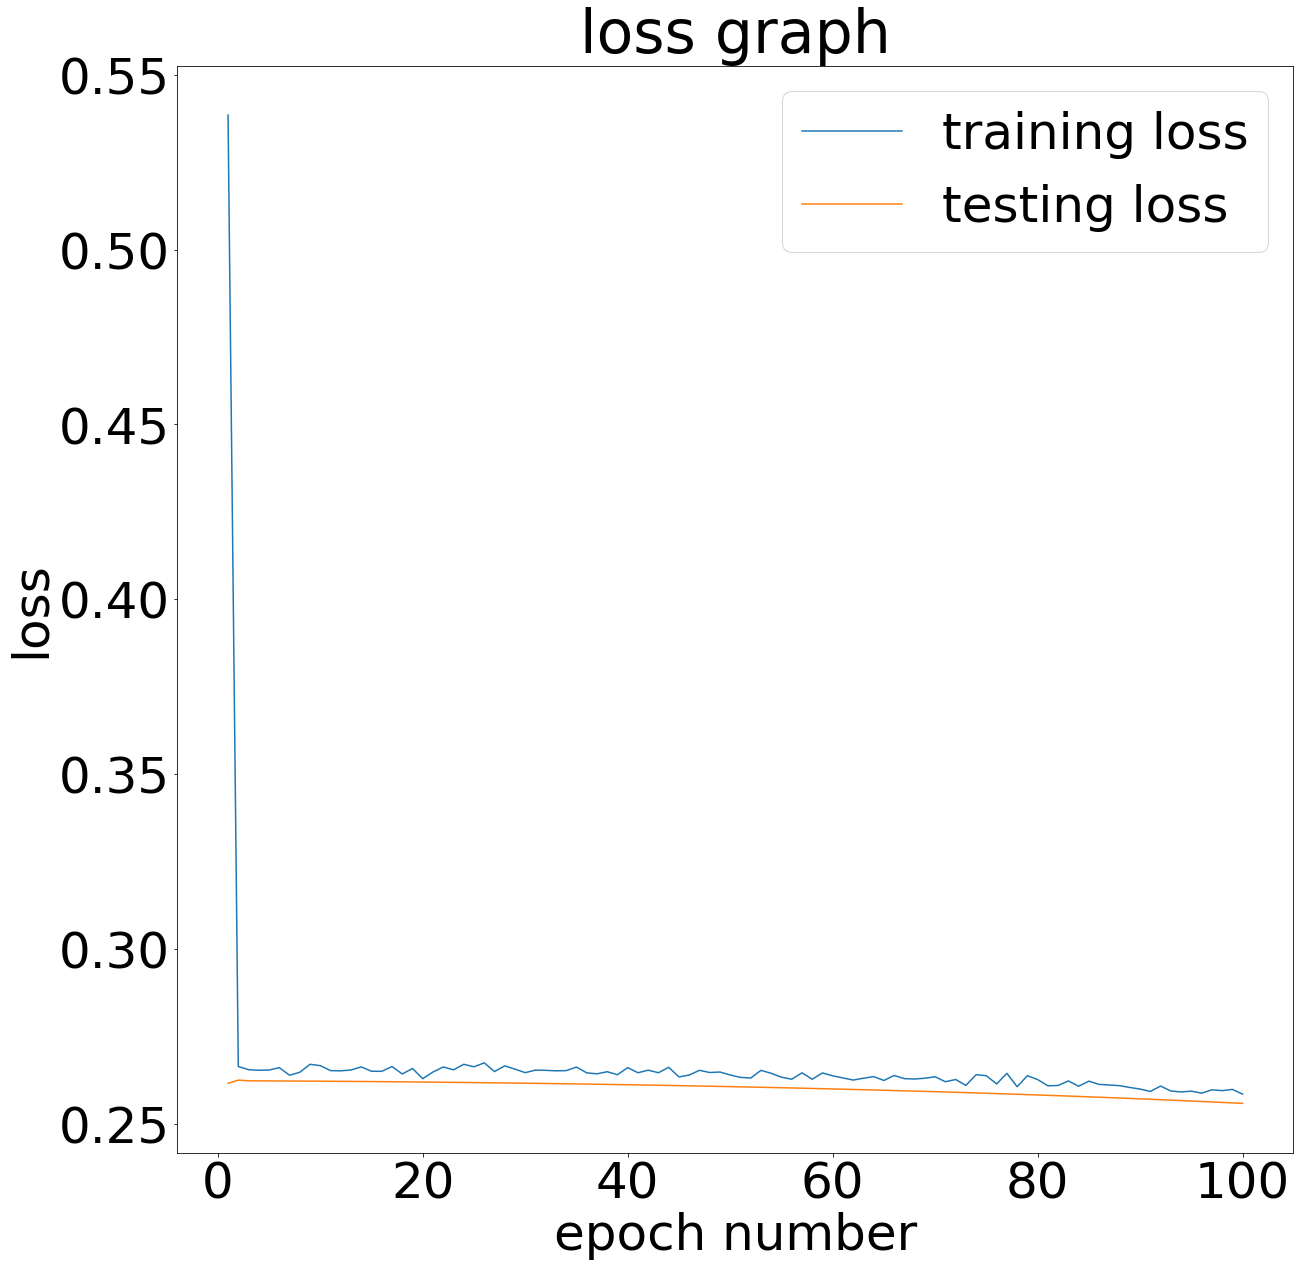

In [52]:
x = range(1, epoch_num+1)

plt.plot(x, loss1, label="training loss")
plt.plot(x, loss2, label="testing loss")
plt.xlabel("epoch number")
#plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
plt.savefig("coordinate-regression-loss.jpg")
plt.rcParams.update({'font.size': 20})
mpl.rcParams['figure.figsize'] = (20, 20)
plt.show()

In [ ]:
torch.save(net, 'shallow.pth')

In [ ]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

labels tensor([[0.4132, 0.6002, 0.4413,  ..., 0.9197, 0.9695, 0.9650],
        [0.4074, 0.5614, 0.4016,  ..., 0.8483, 0.8886, 0.8867],
        [0.4298, 0.5387, 0.4155,  ..., 0.9275, 0.9624, 0.9651],
        ...,
        [0.4504, 0.5843, 0.4588,  ..., 0.8927, 0.9246, 0.9330],
        [0.4429, 0.6054, 0.4605,  ..., 0.9223, 0.9584, 0.9622],
        [0.3852, 0.5666, 0.3852,  ..., 0.8590, 0.9113, 0.9105]])
ret: tensor([[0.4313, 0.6242, 0.4340,  ..., 0.9481, 0.9841, 0.9957],
        [0.3667, 0.5132, 0.3654,  ..., 0.7074, 0.7557, 0.7590],
        [0.4773, 0.6082, 0.4685,  ..., 0.8931, 0.9449, 0.9498],
        ...,
        [0.4347, 0.5622, 0.4365,  ..., 0.8286, 0.8472, 0.8570],
        [0.5247, 0.6647, 0.5203,  ..., 0.8734, 0.9269, 0.9220],
        [0.3729, 0.5442, 0.3794,  ..., 0.7784, 0.8372, 0.8388]],
       device='cuda:0', grad_fn=<ViewBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addit

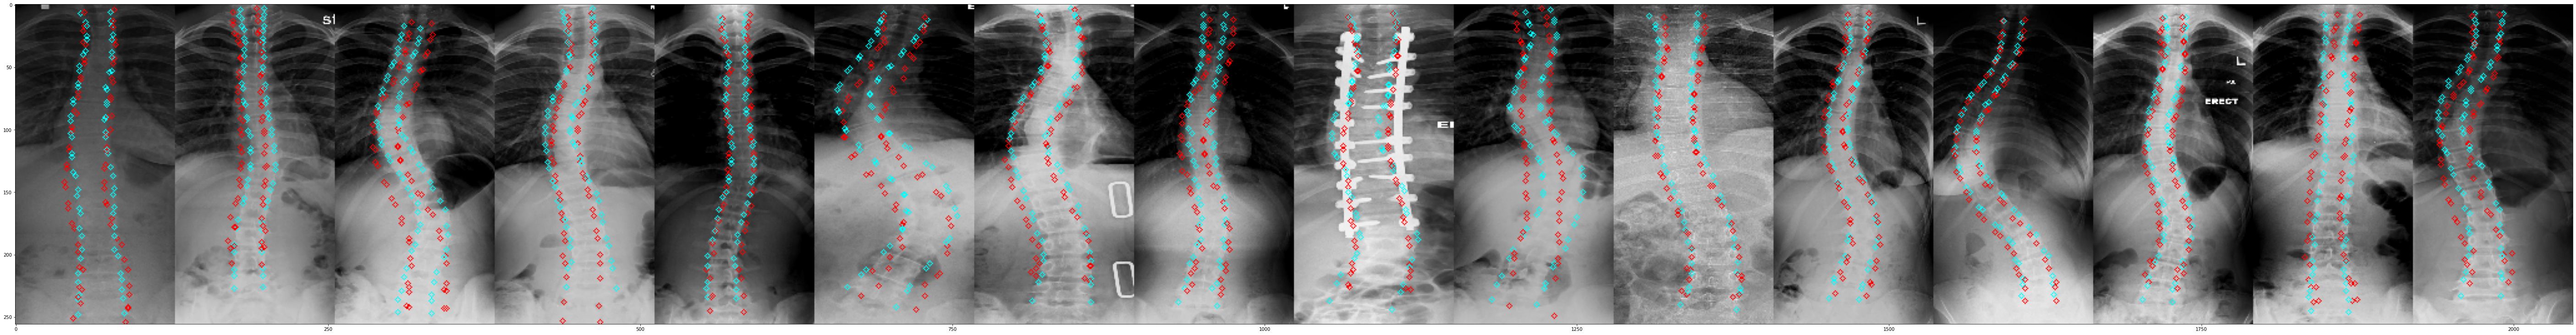

In [ ]:
# visualize result
# note: opencv will take image as BGR but plt.imshow will take as RGB. 
# plt.show need int for 0-255 scale or float for 0-1 scale at each pixel

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (100, 100)

dataiter = iter(train_loader)
images, labels = dataiter.next()
print("labels", labels)
batch, channel, height, width = images.shape
# note: images.shape = (batch, channel, width, height)

ret = net(images.to(device))
print("ret:", ret)
batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    label = labels[i]
    predict = ret[i]

    point_num = len(label) // 2
    for j in range(point_num):
        cv.circle(sample_BGR, (int(label[j] * width), int(label[j + point_num]* height)), 2, (255, 255, 0))
        cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img
    
    
plt.imshow(batch_img)
